In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.model_selection import StratifiedKFold, train_test_split
import itertools

In [2]:
import optuna
from sklearn.model_selection import cross_val_score

In [3]:
from sklearn.svm import SVC

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Load the training dataset for emoticons from the CSV file
train_emoticon_df = pd.read_csv("train_emoticon.csv")

# Shuffle the training dataset randomly using a fixed random state for reproducibility
train_emoticon_df = train_emoticon_df.sample(frac=1, random_state=42)

# Extract the 'input_emoticon' column as a list for training input data (features)
train_emoticon_X = train_emoticon_df['input_emoticon'].tolist()

# Extract the 'label' column as a list for training target data (labels)
train_emoticon_Y = train_emoticon_df['label'].tolist()

# Load the validation dataset for emoticons from the CSV file
val_emoticon_df = pd.read_csv("valid_emoticon.csv")

# Extract the 'input_emoticon' column as a list for validation input data (features)
val_emoticon_X = val_emoticon_df['input_emoticon'].tolist()

# Extract the 'label' column as a list for validation target data (labels)
val_emoticon_Y = val_emoticon_df['label'].tolist()

**ENCODING THE EMOJI'S DATA**
---

In [6]:
unique_emojis = list(set(''.join(train_emoticon_X)))

# Print the total number of unique emojis
print(f"Total unique emojis: {len(unique_emojis)}")

# Initialize the OneHotEncoder to convert emojis into a one-hot encoded format
emoji_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit the encoder with unique emojis wrapped in list format
emoji_encoder.fit([[emoji] for emoji in unique_emojis])

# Transform the training sequences into one-hot encoded format
encoded_train_data = [
    emoji_encoder.transform([[emoji] for emoji in emoji_sequence]) for emoji_sequence in train_emoticon_X
]

# Transform the validation sequences into one-hot encoded format
encoded_val_data = [
    emoji_encoder.transform([[emoji] for emoji in emoji_sequence]) for emoji_sequence in val_emoticon_X
]

# Flatten the one-hot encoded arrays for each sequence in the training set
encoded_train_data = [
    list(itertools.chain.from_iterable(encoded_sequence)) for encoded_sequence in encoded_train_data
]

# Flatten the one-hot encoded arrays for each sequence in the validation set
encoded_val_data = [
    list(itertools.chain.from_iterable(encoded_sequence)) for encoded_sequence in encoded_val_data
]

Total unique emojis: 214


**TRYING DIFFERENT ML MODELS**
---

**1)LOGISTIC REGRESSION**

In [8]:
# Initialize a Logistic Regression model with specific hyperparameters
# C=10: Regularization strength (lower values specify stronger regularization)
# penalty='l1': L1 regularization (Lasso), which encourages sparsity in the model
# solver='saga': An optimization algorithm that supports L1 regularization for large datasets
lr = LogisticRegression(C=10, penalty='l1', solver='saga')

# Train the logistic regression model using the encoded training data
# encoded_train_data: Feature matrix for training data
# train_emoticon_Y: Target labels for training data
model = lr.fit(encoded_train_data, train_emoticon_Y)

# Make predictions on the training data
# This checks how well the model fits the data it was trained on
pred = model.predict(encoded_train_data)

# Make predictions on the validation data
# This checks the model's performance on unseen validation data
pred2 = model.predict(encoded_val_data)

In [9]:
# Calculate the accuracy of the model on the training data
# accuracy_score compares the true labels (train_emoticon_Y) with the predictions (pred)
accuracy = accuracy_score(train_emoticon_Y, pred)

# Calculate the accuracy of the model on the validation data
# accuracy_score compares the true labels (val_emoticon_Y) with the validation predictions (pred2)
accuracy2 = accuracy_score(val_emoticon_Y, pred2)

# Print the model's accuracy on the training data, formatted to 2 decimal places
print(f"Model accuracy for training data is: {accuracy * 100:.2f}%")

# Print the model's accuracy on the validation (test) data, formatted to 2 decimal places
print(f"Model accuracy for validation data is: {accuracy2 * 100:.2f}%")

Model accuracy for training data is: 99.96%
Model accuracy for test data is: 93.25%


In [12]:
# Convert the encoded training data (encoded_train_data) to a NumPy array
# This ensures the data is in the proper format for model training (if needed)
encoded_train_data2 = np.array(encoded_train_data)

# Convert the training labels (train_emoticon_Y) to a NumPy array
# This ensures consistency in data format, which may be required for certain models or libraries
train_emoticon_Y2 = np.array(train_emoticon_Y)


encoded_val_data2=np.array(encoded_val_data)

val_emoticon_Y2=np.array(val_emoticon_Y)

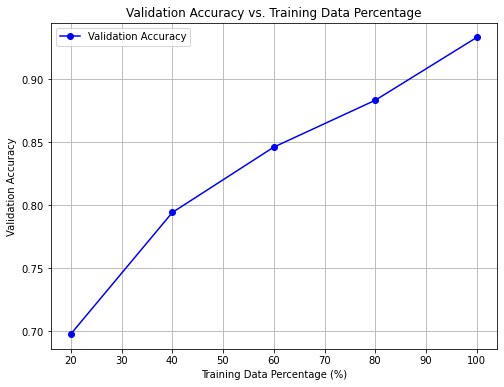

In [13]:
# Define the fractions (percentages) of training data to use
fraction = [20, 40, 60, 80, 100]

# List to store the average validation accuracies for each fraction of training data
validation_accuracies = []

# Loop through each fraction of data
for it in fraction:
    # Set up 5-fold cross-validation with stratified splitting to preserve class distribution
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_accuracies = []  # List to store accuracies for each fold
    
    # Perform the cross-validation
    for train_index, _ in kf.split(encoded_train_data2, train_emoticon_Y2):
        # Split the training data into a subset corresponding to 'it%' for training
        if it < 100:
            # Randomly select 'it%' of the training data
            X_train_subset, _, y_train_subset, _ = train_test_split(
                encoded_train_data2[train_index], train_emoticon_Y2[train_index], 
                train_size=it * 0.01, random_state=42
            )
        else:
            # If using 100%, select the entire training set
            X_train_subset, y_train_subset = encoded_train_data2, train_emoticon_Y2
        
        # Initialize the Logistic Regression model with L1 regularization and 'saga' solver
        lr = LogisticRegression(C=10, penalty='l1', solver='saga')
        
        # Train the model on the selected subset of training data
        model = lr.fit(X_train_subset, y_train_subset)
        
        # Make predictions on the entire validation set
        y_pred = model.predict(encoded_val_data2)
        
        # Calculate accuracy on the validation set
        accuracy = accuracy_score(val_emoticon_Y2, y_pred)
        fold_accuracies.append(accuracy)  # Store the accuracy for this fold
    
    # Compute the average accuracy for this fraction of training data
    avg_accuracy = np.mean(fold_accuracies)
    
    # Append the average validation accuracy to the list for plotting later
    validation_accuracies.append(avg_accuracy)

# Plotting the graph
plt.figure(figsize=(8, 6))  # Set the figure size for the plot
plt.plot(fraction, validation_accuracies, marker='o', linestyle='-', color='b', label='Validation Accuracy')

# Add labels to the x-axis and y-axis
plt.xlabel('Training Data Percentage (%)')
plt.ylabel('Validation Accuracy')

# Add a title to the plot
plt.title('Validation Accuracy vs. Training Data Percentage')

# Enable grid lines for better visualization
plt.grid(True)

# Add a legend to the plot
plt.legend()

# Display the plot
plt.show()

**2)DECISION TREES**

In [14]:
# Initialize a Decision Tree Classifier with default hyperparameters
dtc = DecisionTreeClassifier()

# Train the decision tree classifier on the encoded training data and labels
# encoded_train_data: Feature matrix for training data
# train_emoticon_Y: Target labels for training data
model = dtc.fit(encoded_train_data, train_emoticon_Y)

# Predict labels for the validation data (encoded_val_data)
# This will give us the predicted labels based on the model's learning
pred = model.predict(encoded_val_data)

# Calculate accuracy on the validation data by comparing predicted labels with true labels
acc = accuracy_score(pred, val_emoticon_Y)*100

# Print the accuracy of the model on the validation data
print("Accuracy of the model on validation data is:", acc)

# Predict labels for the training data to calculate training accuracy
pred_train = model.predict(encoded_train_data)

# Calculate the accuracy of the model on the training data
train_acc = accuracy_score(pred_train, train_emoticon_Y)*100

# Print the accuracy of the model on the training data
print("Accuracy of the model on training data is:", train_acc)

Accuracy of the model on validation data is: 0.7586912065439673
Accuracy of the model on training data is: 1.0


In [11]:
def objective(trial):
    # Suggest values for the hyperparameters using Optuna
    # max_depth: The maximum depth of the decision tree, controlling its size
    max_depth = trial.suggest_int('max_depth', 300, 500)
    
    # min_samples_split: The minimum number of samples required to split a node
    min_samples_split = trial.suggest_int('min_samples_split', 10, 20)
    
    # criterion: The function to measure the quality of a split ('gini' or 'entropy')
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    
    # Initialize the Decision Tree Classifier with the suggested hyperparameters
    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        criterion=criterion,
        random_state=42  # Ensures reproducibility
    )
    
    # Evaluate the model using 5-fold cross-validation on the training data
    # cross_val_score returns the accuracy score for each fold; we take the mean accuracy
    score = cross_val_score(model, encoded_train_data, train_emoticon_Y, cv=5, scoring='accuracy').mean()
    
    # Return the mean cross-validation score as the objective value
    return score

# Create an Optuna study object for hyperparameter optimization
# direction='maximize' indicates we want to maximize the accuracy score
study = optuna.create_study(direction='maximize')

# Run the optimization process for the defined number of trials (10 in this case)
study.optimize(objective, n_trials=10)

# Retrieve the best hyperparameters from the study
best_params = study.best_params
print("Best Hyperparameters: ", best_params)

# Train the Decision Tree Classifier with the best hyperparameters
best_model = DecisionTreeClassifier(**best_params, random_state=42)

# Fit the model to the full training dataset
best_model.fit(encoded_train_data, train_emoticon_Y)

# Evaluate the model on the validation data and calculate the accuracy
accuracy = best_model.score(encoded_val_data, val_emoticon_Y)

# Print the accuracy on the validation set (formatted to 4 decimal places)
print(f"Accuracy on test set: {accuracy:.4f}")

[I 2024-10-12 18:17:47,950] A new study created in memory with name: no-name-0b48bc21-85ea-437a-a81a-4b68fb6a8f27
[I 2024-10-12 18:19:31,799] Trial 0 finished with value: 0.7819209039548023 and parameters: {'max_depth': 454, 'min_samples_split': 13, 'criterion': 'gini'}. Best is trial 0 with value: 0.7819209039548023.
[I 2024-10-12 18:21:08,318] Trial 1 finished with value: 0.7837570621468926 and parameters: {'max_depth': 368, 'min_samples_split': 17, 'criterion': 'gini'}. Best is trial 1 with value: 0.7837570621468926.
[I 2024-10-12 18:23:00,337] Trial 2 finished with value: 0.7755649717514124 and parameters: {'max_depth': 446, 'min_samples_split': 10, 'criterion': 'gini'}. Best is trial 1 with value: 0.7837570621468926.
[I 2024-10-12 18:24:51,574] Trial 3 finished with value: 0.7829096045197741 and parameters: {'max_depth': 458, 'min_samples_split': 12, 'criterion': 'gini'}. Best is trial 1 with value: 0.7837570621468926.
[I 2024-10-12 18:26:37,324] Trial 4 finished with value: 0.778

Best Hyperparameters:  {'max_depth': 395, 'min_samples_split': 19, 'criterion': 'gini'}
Accuracy on test set: 0.7873


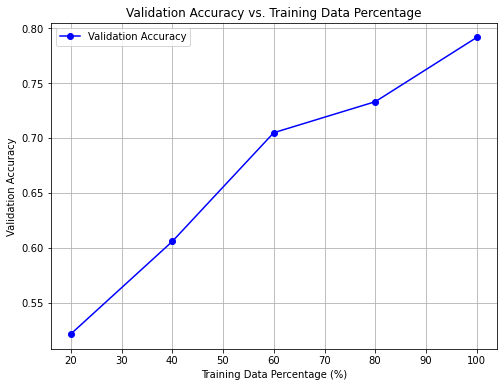

In [15]:
# Define the fractions (percentages) of the training data to use for training the model
fraction = [20, 40, 60, 80, 100]

# List to store the average validation accuracies for each fraction of training data
validation_accuracies = []

# Loop through each fraction of data (20%, 40%, 60%, 80%, 100%)
for it in fraction:
    # StratifiedKFold is used to split the data into 5 folds, ensuring class distribution is maintained
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_accuracies = []  # List to store accuracies for each fold in this fraction

    # Perform cross-validation
    for train_index, _ in kf.split(encoded_train_data2, train_emoticon_Y2):
        # Split the training data into 'it%' for training and discard the rest
        if it < 100:
            # Use train_test_split to randomly sample 'it%' of the training data
            X_train_subset, _, y_train_subset, _ = train_test_split(
                encoded_train_data2[train_index], train_emoticon_Y2[train_index], 
                train_size=it * 0.01, random_state=42  # 'it * 0.01' converts percentage to fraction
            )
        else:
            # If using 100%, select the entire training set
            X_train_subset, y_train_subset = encoded_train_data2, train_emoticon_Y2

        # Train the Decision Tree Classifier using the selected subset of training data
        lr = DecisionTreeClassifier(max_depth=395, min_samples_split=19, criterion='gini')
        model = lr.fit(X_train_subset, y_train_subset)

        # Predict the labels on the entire validation set
        y_pred = model.predict(encoded_val_data2)

        # Calculate the accuracy on the validation set and append it to the fold accuracies
        accuracy = accuracy_score(val_emoticon_Y2, y_pred)
        fold_accuracies.append(accuracy)
    
    # Compute the average accuracy across all folds for the current fraction of training data
    avg_accuracy = np.mean(fold_accuracies)
    
    # Append the average accuracy to the list for plotting later
    validation_accuracies.append(avg_accuracy)

# Plotting the graph of fraction of training data vs. validation accuracy
plt.figure(figsize=(8, 6))  # Set the size of the plot
plt.plot(fraction, validation_accuracies, marker='o', linestyle='-', color='b', label='Validation Accuracy')

# Add labels to the x-axis and y-axis
plt.xlabel('Training Data Percentage (%)')
plt.ylabel('Validation Accuracy')

# Add a title to the plot
plt.title('Validation Accuracy vs. Training Data Percentage')

# Enable grid lines for better visualization
plt.grid(True)

# Add a legend to the plot
plt.legend()

# Display the plot
plt.show()


**3)RANDOM FOREST CLASSIFIER**

In [22]:
# Initialize a Random Forest Classifier with default hyperparameters
rf = RandomForestClassifier()

# Fit the Random Forest model on the encoded training data and corresponding labels
# encoded_train_data2: Feature matrix for training data
# train_emoticon_Y2: Target labels for training data
model = rf.fit(encoded_train_data2, train_emoticon_Y2)

# Predict labels for the validation data (encoded_val_data2)
# This will give us the predicted labels based on the model's learning
pred = model.predict(encoded_val_data2)

# Calculate accuracy on the validation data by comparing predicted labels with true labels
acc = accuracy_score(pred, val_emoticon_Y2)*100

# Print the accuracy of the model on the validation data
print("Accuracy of the current model on validation data is:", acc)

# Predict labels for the training data to calculate training accuracy
pred_train = model.predict(encoded_train_data2)

# Calculate the accuracy of the model on the training data
train_acc = accuracy_score(pred_train, train_emoticon_Y2)*100

# Print the accuracy of the model on the training data
print("Accuracy of the current model on training data is:", train_acc)


Accuracy of the current model on validation data is: 81.79959100204499
Accuracy of the current model on training data is: 100.0


In [24]:
def objective(trial):
    # Suggest values for hyperparameters to be tuned
    max_depth = trial.suggest_categorical('max_depth', np.linspace(450, 500, 6, dtype=int))  # Depth of the tree
    max_leaf_nodes = trial.suggest_categorical('max_leaf_nodes', [1500, 1700, 1900, 2200])  # Maximum number of leaf nodes
    # Uncomment below to tune the minimum samples required to be at a leaf node
    # min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])  # Criterion for splitting

    # Initialize the Random Forest Classifier with the suggested hyperparameters
    model = RandomForestClassifier(
        max_depth=max_depth,
        max_leaf_nodes=max_leaf_nodes,
        criterion=criterion,
        random_state=42  # For reproducibility
    )
    
    # Evaluate the model using cross-validation
    # Compute the mean accuracy score across 5 folds
    score = cross_val_score(model, encoded_train_data, train_emoticon_Y, cv=5, scoring='accuracy').mean()
    
    return score  # Return the mean accuracy score for the current set of hyperparameters

# Create an Optuna study to optimize the objective function
study = optuna.create_study(direction='maximize')  # Aim to maximize the score
study.optimize(objective, n_trials=10)  # Optimize for 10 trials

# Retrieve the best hyperparameters found during optimization
best_params = study.best_params
print("Best Hyperparameters: ", best_params)  # Print the best hyperparameters

# Train the Random Forest model using the best hyperparameters obtained
best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(encoded_train_data, train_emoticon_Y)  # Fit the model to the training data

# Evaluate the model on the validation set
accuracy = best_model.score(encoded_val_data, val_emoticon_Y)  # Calculate accuracy
print(f"Accuracy on test set: {accuracy:.4f}")  # Print the accuracy with 4 decimal places

[I 2024-10-19 15:17:28,543] A new study created in memory with name: no-name-f043478e-a592-4dac-bc91-10c6ecb788d4
[I 2024-10-19 15:19:18,650] Trial 0 finished with value: 0.7950564971751412 and parameters: {'max_depth': 470, 'min_samples_split': 1700, 'criterion': 'gini'}. Best is trial 0 with value: 0.7950564971751412.
[I 2024-10-19 15:21:14,770] Trial 1 finished with value: 0.7930790960451978 and parameters: {'max_depth': 500, 'min_samples_split': 2200, 'criterion': 'gini'}. Best is trial 0 with value: 0.7950564971751412.
[I 2024-10-19 15:23:26,760] Trial 2 finished with value: 0.8159604519774011 and parameters: {'max_depth': 480, 'min_samples_split': 1500, 'criterion': 'entropy'}. Best is trial 2 with value: 0.8159604519774011.
[I 2024-10-19 15:25:38,881] Trial 3 finished with value: 0.8149717514124294 and parameters: {'max_depth': 470, 'min_samples_split': 1700, 'criterion': 'entropy'}. Best is trial 2 with value: 0.8159604519774011.
[I 2024-10-19 15:27:56,022] Trial 4 finished wit

Best Hyperparameters:  {'max_depth': 450, 'min_samples_split': 1500, 'criterion': 'entropy'}
Accuracy on test set: 0.8323


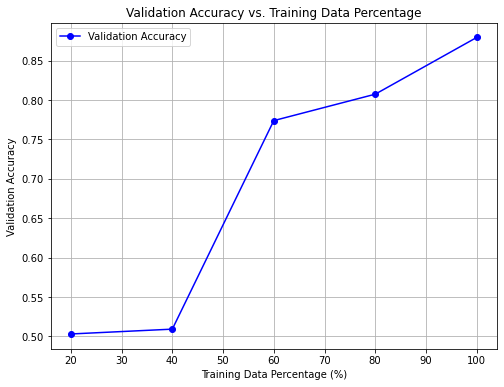

In [25]:
# Define the fractions (percentages) of the training data to use for training the model
fraction = [20, 40, 60, 80, 100]

# List to store the average validation accuracies for each fraction of training data
validation_accuracies = []

# Loop through each fraction of data (20%, 40%, 60%, 80%, 100%)
for it in fraction:
    # StratifiedKFold is used to split the data into 5 folds, ensuring class distribution is maintained
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_accuracies = []  # List to store accuracies for each fold in this fraction

    # Perform cross-validation
    for train_index, _ in kf.split(encoded_train_data2, train_emoticon_Y2):
        # Split the training data into 'it%' for training and discard the rest
        if it < 100:
            # Use train_test_split to randomly sample 'it%' of the training data
            X_train_subset, _, y_train_subset, _ = train_test_split(
                encoded_train_data2[train_index], train_emoticon_Y2[train_index], 
                train_size=it * 0.01, random_state=42  # 'it * 0.01' converts percentage to fraction
            )
        else:
            # If using 100%, select the entire training set
            X_train_subset, y_train_subset = encoded_train_data2, train_emoticon_Y2

        # Train the Decision Tree Classifier using the selected subset of training data
        lr = RandomForestClassifier(**best_params, random_state=42)
        model = lr.fit(X_train_subset, y_train_subset)

        # Predict the labels on the entire validation set
        y_pred = model.predict(encoded_val_data2)

        # Calculate the accuracy on the validation set and append it to the fold accuracies
        accuracy = accuracy_score(val_emoticon_Y2, y_pred)
        fold_accuracies.append(accuracy)
    
    # Compute the average accuracy across all folds for the current fraction of training data
    avg_accuracy = np.mean(fold_accuracies)
    
    # Append the average accuracy to the list for plotting later
    validation_accuracies.append(avg_accuracy)

# Plotting the graph of fraction of training data vs. validation accuracy
plt.figure(figsize=(8, 6))  # Set the size of the plot
plt.plot(fraction, validation_accuracies, marker='o', linestyle='-', color='b', label='Validation Accuracy')

# Add labels to the x-axis and y-axis
plt.xlabel('Training Data Percentage (%)')
plt.ylabel('Validation Accuracy')

# Add a title to the plot
plt.title('Validation Accuracy vs. Training Data Percentage')

# Enable grid lines for better visualization
plt.grid(True)

# Add a legend to the plot
plt.legend()

# Display the plot
plt.show()

**4)SVM**

In [26]:
# Initialize the Support Vector Classifier with a linear kernel
rf = svm_classifier = SVC(kernel='linear')  # Create an instance of the SVC with a linear kernel

# Fit the model to the training data
model = rf.fit(encoded_train_data2, train_emoticon_Y2)  # Train the model on the encoded training data

# Make predictions on the validation data
pred = model.predict(encoded_val_data2)  # Predict labels for the validation set

# Calculate accuracy on the validation set
acc = accuracy_score(pred, val_emoticon_Y2)*100  # Compute the accuracy score by comparing predictions to true labels
print("Accuracy of the current model is:", acc)  # Print the accuracy of the current model on the validation set

Accuracy of the current model is: 89.77505112474438


In [24]:
# Define the objective function for Optuna
def objective(trial):
    # Suggest values for the hyperparameters to be tuned
    C = trial.suggest_categorical('C', [.5, .7, .9, 1.5, 2, 3, 4, 5, 6, 7, 10])  # Regularization parameter

    # Initialize the Support Vector Classifier with the suggested hyperparameter
    model = SVC(kernel='linear', C=C)  # Create an instance of SVC with a linear kernel and the chosen C value
    
    # Evaluate the model using cross-validation
    # Compute the mean accuracy score across 5 folds
    score = cross_val_score(model, encoded_train_data, train_emoticon_Y, cv=5, scoring='accuracy').mean()
    
    return score  # Return the mean accuracy score for the current set of hyperparameters

# Create an Optuna study to optimize the objective function
study = optuna.create_study(direction='maximize')  # Aim to maximize the score
study.optimize(objective, n_trials=10)  # Optimize the objective function for 10 trials

# Retrieve the best hyperparameters found during optimization
best_params = study.best_params  # Get the best hyperparameters from the study
print("Best Hyperparameters: ", best_params)  # Print the best hyperparameters

# Train the model with the best hyperparameters
best_model = SVC(**best_params, random_state=42)  # Create the SVC model with the best parameters
best_model.fit(encoded_train_data, train_emoticon_Y)  # Fit the model to the training data

# Evaluate the model on the validation set
accuracy = best_model.score(encoded_val_data, val_emoticon_Y)  # Calculate accuracy on the validation set
print(f"Accuracy on validation set: {accuracy:.4f}")  # Print the accuracy on the validation set with 4 decimal places

# Optionally, evaluate the model on a separate test set (if available)
# If you have a test dataset, you can calculate the accuracy as follows:
# test_accuracy = best_model.score(encoded_test_data, test_emoticon_Y)  # Calculate accuracy on the test set
# print(f"Accuracy on test set: {test_accuracy:.4f}")  # Print the accuracy on the test set with 4 decimal places


[I 2024-10-12 21:40:41,339] A new study created in memory with name: no-name-c190fe6c-f653-4e89-8ea5-8b5660662717
[I 2024-10-12 21:43:02,969] Trial 0 finished with value: 0.8556497175141242 and parameters: {'C': 10}. Best is trial 0 with value: 0.8556497175141242.
[I 2024-10-12 21:45:17,779] Trial 1 finished with value: 0.8443502824858757 and parameters: {'C': 0.9}. Best is trial 0 with value: 0.8556497175141242.
[I 2024-10-12 21:47:34,875] Trial 2 finished with value: 0.8423728813559321 and parameters: {'C': 0.7}. Best is trial 0 with value: 0.8556497175141242.
[I 2024-10-12 21:49:46,782] Trial 3 finished with value: 0.8539548022598871 and parameters: {'C': 2}. Best is trial 0 with value: 0.8556497175141242.
[I 2024-10-12 21:52:12,566] Trial 4 finished with value: 0.8576271186440678 and parameters: {'C': 7}. Best is trial 4 with value: 0.8576271186440678.
[I 2024-10-12 21:54:40,637] Trial 5 finished with value: 0.8564971751412429 and parameters: {'C': 5}. Best is trial 4 with value: 0

Best Hyperparameters:  {'C': 7}
Accuracy on test set: 0.8241


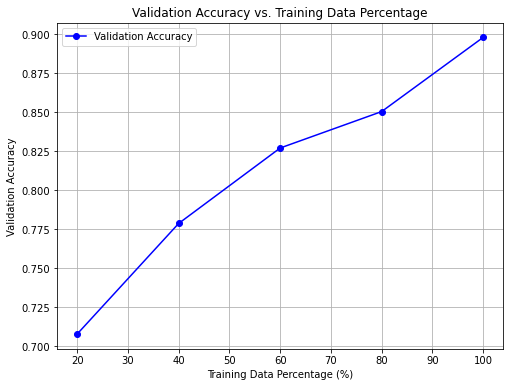

In [27]:
# Define the fractions of the training data to be used for evaluation
fraction = [20, 40, 60, 80, 100]  # List of percentages to evaluate
validation_accuracies = []  # Initialize a list to store validation accuracies for each fraction

# Iterate over the defined fractions
for it in fraction:
    # Initialize StratifiedKFold for cross-validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Create 5-fold cross-validation
    fold_accuracies = []  # List to store accuracies for each fold
    
    # Perform cross-validation
    for train_index, _ in kf.split(encoded_train_data2, train_emoticon_Y2):
        # Split the training data to 'it%' of the total data
        if it < 100:
            X_train_subset, _, y_train_subset, _ = train_test_split(
                encoded_train_data2[train_index], train_emoticon_Y2[train_index], 
                train_size=it * 0.01, random_state=42  # Use 'it%' of the training data
            )
        else:
            # Use all data if 'it' is 100%
            X_train_subset, y_train_subset = encoded_train_data2, train_emoticon_Y2
        
        # Train the model on the selected subset of training data
        lr = SVC(kernel='linear')  # Initialize the Support Vector Classifier with a linear kernel
        model = lr.fit(X_train_subset, y_train_subset)  # Fit the model to the training subset
        
        # Predict labels on the entire validation set
        y_pred = model.predict(encoded_val_data2)  # Generate predictions for the validation set
        
        # Calculate accuracy on the validation set
        accuracy = accuracy_score(val_emoticon_Y2, y_pred)  # Compute accuracy by comparing predictions to true labels
        fold_accuracies.append(accuracy)  # Store the accuracy for this fold
    
    # Compute the average accuracy across all folds for this fraction
    avg_accuracy = np.mean(fold_accuracies)  # Calculate the mean accuracy from the fold accuracies
    validation_accuracies.append(avg_accuracy)  # Append the average accuracy to the list of validation accuracies

# Plotting the graph to visualize the relationship between training data percentage and validation accuracy
plt.figure(figsize=(8, 6))  # Set the figure size for the plot
plt.plot(fraction, validation_accuracies, marker='o', linestyle='-', color='b', label='Validation Accuracy')  # Plot validation accuracy

# Add labels and title to the plot
plt.xlabel('Training Data Percentage (%)')  # Label for the x-axis
plt.ylabel('Validation Accuracy')  # Label for the y-axis
plt.title('Validation Accuracy vs. Training Data Percentage')  # Title of the plot
plt.grid(True)  # Enable grid for better readability
plt.legend()  # Show legend for the plot

# Display the plot
plt.show()  # Render the plot to the screen
